# Machine Learning Task

## 1. Load the dataset

In [1]:
from PIL import Image
from datasets import load_dataset
import torch
from utils.visualization_utils import get_best_pic, get_worst_pic, get_all_sorted_pics, images_to_tensor
from models.hpsv2_model import HPSv2Module
import hpsv2
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
# load dataset
dataset = load_dataset("zhwang/HPDv2", split="test")

Repo card metadata block was not found. Setting CardData to empty.


In [3]:
print(len(dataset))

400


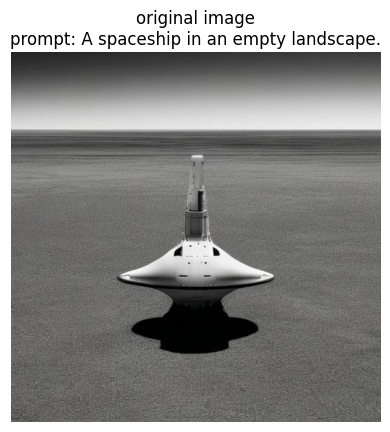

In [4]:
# test the nth sample
n = 101
image_path, prompt = get_best_pic(dataset, n)
# plot the image
image = Image.open(image_path).convert("RGB")
plt.imshow(image)
plt.axis('off')
plt.title("original image"+"\n"+"prompt: "+prompt)
plt.show()


## 2. Load the model

In [5]:
# initialize the model
# HPSv2_model = HPSv2Scorer("weights/HPS_v2_compressed.pt")
model = HPSv2Module("weights/HPS_v2_compressed.pt", device="cuda")


In [6]:
n = 101
image_paths, prompt = get_all_sorted_pics(dataset, n)
# image_tensor = model.preprocess(Image.open(image_paths).convert("RGB")).unsqueeze(0).to(model.device, dtype=torch.float32)
image_tensors = images_to_tensor(image_paths, model)
score = model.score(image_tensors, prompt)

print("Prompt:", prompt)
print("Image path:", image_paths)
print("Score:", score)


Prompt: A spaceship in an empty landscape.
Image path: ['data/test/00911.jpg', 'data/test/00910.jpg', 'data/test/00912.jpg', 'data/test/00909.jpg', 'data/test/00913.jpg', 'data/test/00914.jpg', 'data/test/00917.jpg', 'data/test/00916.jpg', 'data/test/00915.jpg']
Score: tensor([26.0000, 25.1250, 25.7344, 25.2500, 25.3906, 25.7500, 25.1875, 25.9062,
        24.0156], dtype=torch.float16)


In [7]:
##test the scoret the score
# image_paths, prompt = get_all_sorted_pics(dataset, 101)
# score = hpsv2.score(image_paths, prompt, hps_version="v2.0")
# print("HPSv2 Score:", score)

In [9]:
# Convert the list to a numpy array to calculate the mean
# import numpy as np
# print(f"Mean score: {np.mean(score)}")

## 3.White Box Attack Test

In [10]:
from utils.attacks import PGDAttack, FGSMAttack
from utils.visualization_utils import show_tensor_with_preprocess_config

attacker = FGSMAttack(model, eps=8/255)
adv_images = attacker.attack(image_tensors, prompt)
# visualize_attack_results(image_tensor, adv_images, model, prompt)
adv_score = model.score(adv_images, prompt)
print("FGSM Adv Score:", adv_score)

# attacker = PGDAttack(model, eps=8/255, alpha=2/255, steps=8)
# adv_images = attacker.attack(image_tensors, prompt)
# adv_score = model.score(adv_images, prompt)
# print("PGD Adv Score:", adv_score)
# show_tensor_with_preprocess_config(adv_images)


FGSM Adv Score: tensor([24.8438, 23.8281, 24.5000, 23.5469, 23.9219, 24.5625, 23.4062, 24.1719,
        22.7344], dtype=torch.float16)


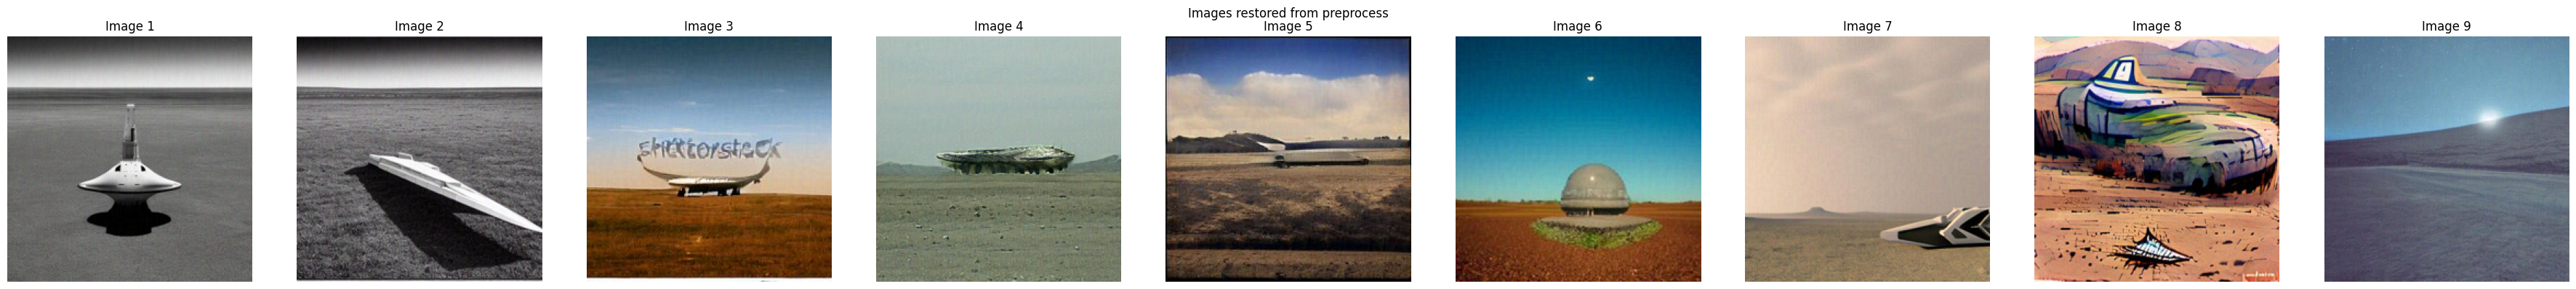

HPSv2 Score of attacked images: [np.float16(0.2482), np.float16(0.2383), np.float16(0.245), np.float16(0.2352), np.float16(0.239), np.float16(0.246), np.float16(0.2335), np.float16(0.241), np.float16(0.2275)]


In [19]:
import os
import numpy as np
def save_attacked_images(adv_images: torch.Tensor, image_paths: list[str]):
    """
    Save a batch of adversarial images to a fixed output directory without quality loss.

    Args:
        adv_images: Tensor of shape (B, 3, H, W) containing normalized images.
        image_paths: List of original image paths to derive filenames.
    """
    # Fixed output directory
    output_dir = os.path.join("outputs", "attacked_images")
    os.makedirs(output_dir, exist_ok=True)
    
    # CLIP normalization parameters
    mean = torch.tensor([0.48145466, 0.4578275, 0.40821073]).view(1, 3, 1, 1)
    std = torch.tensor([0.26862954, 0.26130258, 0.27577711]).view(1, 3, 1, 1)
    
    save_paths = []

    # Check if adv_images is a sparse tensor and convert to dense if needed
    if adv_images.is_sparse:
        adv_images = adv_images.to_dense()
        
    # For batch show all images
    imgs = adv_images.detach().cpu()
    num_images = imgs.size(0)
    for i in range(num_images):
        img = imgs[i] * std + mean
        img = img.squeeze(0)
        img_np = img.permute(1, 2, 0).clamp(0, 1).numpy()
        pil_img = Image.fromarray((img_np * 255).astype(np.uint8))
        orig_filename = os.path.basename(image_paths[i])
        filename, _ = os.path.splitext(orig_filename)
        # Save as PNG to avoid JPEG compression artifacts
        save_path = os.path.join(output_dir, f"{filename}.png")
        pil_img.save(save_path, format='PNG')
        save_paths.append(save_path)
    return save_paths

show_tensor_with_preprocess_config(adv_images)
save_paths = save_attacked_images(adv_images, image_paths)
score = hpsv2.score(save_paths, prompt, hps_version="v2.0")
print("HPSv2 Score of attacked images:", score)

## 4.Black Box Attack Test


## nes

In [1]:
from PIL import Image
from datasets import load_dataset
import torch
from utils.visualization_utils import get_best_pic, get_worst_pic, get_all_pics, images_to_tensor,save_attacked_images
from models.hpsv2_model import HPSv2Module
import hpsv2
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
from datasets import load_dataset
dataset = load_dataset("zhwang/HPDv2", split="test")


Repo card metadata block was not found. Setting CardData to empty.


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = HPSv2Module("weights/HPS_v2_compressed.pt", device=device)

In [4]:
image_paths, prompt = get_all_pics(dataset, 0)
print(image_paths)

# image_tensor = images_to_tensor([image_paths[0]], model).to(device)
image_tensor = images_to_tensor([image_paths[0]], model).to(device)


['data/test/00000.jpg', 'data/test/00001.jpg', 'data/test/00002.jpg', 'data/test/00003.jpg', 'data/test/00004.jpg', 'data/test/00005.jpg', 'data/test/00006.jpg', 'data/test/00007.jpg', 'data/test/00008.jpg']


In [ ]:
from utils.attacks import NESAttack
nes_attacker = NESAttack(model, eps=8/255, alpha=2/255, steps=13, nes_samples=25, device="cuda")

adv_image = nes_attacker.attack(image_tensor, prompt)
attacked_score_v2_0 = model.score(adv_image, prompt)
print(f"Attacked score v2.0: {attacked_score_v2_0}")


### Small Image Test to check the relation between the steps and the score drop rate

In [2]:
from PIL import Image
from datasets import load_dataset
import torch
from utils.visualization_utils import get_best_pic, get_worst_pic, get_all_pics, images_to_tensor,save_attacked_images
from models.hpsv2_model import HPSv2Module
import hpsv2
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from utils.attacks import NESAttack
from datasets import load_dataset
dataset = load_dataset("zhwang/HPDv2", split="test")
device = "cuda" if torch.cuda.is_available() else "cpu"
model = HPSv2Module("weights/HPS_v2_compressed.pt", device=device)


Repo card metadata block was not found. Setting CardData to empty.


In [3]:
import pandas as pd
image_paths, prompt = get_all_pics(dataset, 0)
image_tensor = images_to_tensor(image_paths, model).to(device)
ORIGINAL_SCORE = model.score(image_tensor, prompt)
print(f"Original score: {ORIGINAL_SCORE}")
mean_original_score = pd.Series(ORIGINAL_SCORE).mean()
print(mean_original_score)

Original score: tensor([22.4375, 23.5781, 25.0312, 22.7188, 21.8438, 18.5625, 24.9531, 23.2344,
        24.0781], dtype=torch.float16)
22.94


In [4]:
from tqdm import tqdm
mean_attacked_score = []
for step in tqdm(range(10,51,5)):
    print(f"Step: {step}")
    attacked_score = []
    for i in range(len(image_paths)):
        image_tensor = images_to_tensor([image_paths[i]], model).to(device)
        nes_attacker = NESAttack(model, eps=8/255, alpha=2/255, steps=step, nes_samples=25, device="cuda")
        adv_image = nes_attacker.attack(image_tensor, prompt)
        attacked_score_v2_0 = model.score(adv_image, prompt)
        attacked_score.append(attacked_score_v2_0)
    mean_attacked_score.append(pd.Series(attacked_score).mean())
    print(f"Attacked score v2.0: {mean_attacked_score}")


  0%|          | 0/9 [00:00<?, ?it/s]

Step: 10
Attacked score v2.0: [np.float64(22.694444444444443)]


 11%|█         | 1/9 [03:11<25:30, 191.29s/it]

Step: 15
Attacked score v2.0: [np.float64(22.694444444444443), np.float64(22.65972222222222)]


 22%|██▏       | 2/9 [08:44<32:02, 274.71s/it]

Step: 20
Attacked score v2.0: [np.float64(22.694444444444443), np.float64(22.65972222222222), np.float64(22.586805555555557)]


 33%|███▎      | 3/9 [18:07<40:39, 406.62s/it]

Step: 25
Attacked score v2.0: [np.float64(22.694444444444443), np.float64(22.65972222222222), np.float64(22.586805555555557), np.float64(22.578125)]


 44%|████▍     | 4/9 [27:06<38:13, 458.71s/it]

Step: 30
Attacked score v2.0: [np.float64(22.694444444444443), np.float64(22.65972222222222), np.float64(22.586805555555557), np.float64(22.578125), np.float64(22.571180555555557)]


 56%|█████▌    | 5/9 [39:53<37:59, 569.96s/it]

Step: 35
Attacked score v2.0: [np.float64(22.694444444444443), np.float64(22.65972222222222), np.float64(22.586805555555557), np.float64(22.578125), np.float64(22.571180555555557), np.float64(22.57465277777778)]


 67%|██████▋   | 6/9 [54:39<33:51, 677.26s/it]

Step: 40
Attacked score v2.0: [np.float64(22.694444444444443), np.float64(22.65972222222222), np.float64(22.586805555555557), np.float64(22.578125), np.float64(22.571180555555557), np.float64(22.57465277777778), np.float64(22.578125)]


 78%|███████▊  | 7/9 [1:09:21<24:48, 744.15s/it]

Step: 45
Attacked score v2.0: [np.float64(22.694444444444443), np.float64(22.65972222222222), np.float64(22.586805555555557), np.float64(22.578125), np.float64(22.571180555555557), np.float64(22.57465277777778), np.float64(22.578125), np.float64(22.555555555555557)]


 89%|████████▉ | 8/9 [1:26:55<14:03, 843.03s/it]

Step: 50
Attacked score v2.0: [np.float64(22.694444444444443), np.float64(22.65972222222222), np.float64(22.586805555555557), np.float64(22.578125), np.float64(22.571180555555557), np.float64(22.57465277777778), np.float64(22.578125), np.float64(22.555555555555557), np.float64(22.557291666666668)]


100%|██████████| 9/9 [1:44:37<00:00, 697.52s/it]


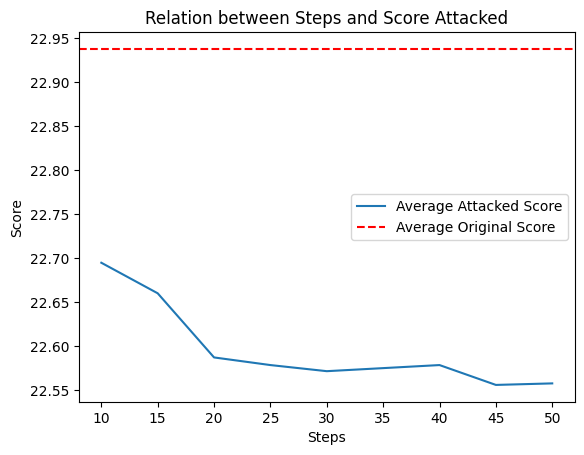

In [9]:


plt.plot(range(10,51,5), mean_attacked_score, label='Average Attacked Score')
plt.axhline(y=mean_original_score, color='r', linestyle='--', label='Average Original Score')
plt.xlabel('Steps')
plt.ylabel('Score')
plt.title('Relation between Steps and Score Attacked')
plt.legend()
plt.show()
